In [379]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
# import sympy as sp
# from numpy.random import default_rng
# from scipy.optimize import curve_fit
# from typing import Optional
# from lmfit.models import SineModel
%matplotlib inline

warnings.simplefilter('ignore')

### Constants

In [380]:
c = 2.998e8 #光の速度
f = 920.4e6 #周波数
WAVE_LENGTH = c / f * 100 #理論波長
THETA_M = 34 * np.pi / 180
MAX_L = WAVE_LENGTH / (2 * np.sin(THETA_M))
L = 25
print(f'波長λ:{WAVE_LENGTH}, Lの最大値:{MAX_L}')
R=45
M = 3 #アンテナの数
K = 2 #信号の数
N = 100 #サンプル数
S = 30 * np.identity(K)

波長λ:32.57279443720122, Lの最大値:29.124828154140907


In [381]:
TARGET_TAG = "E200 4216 0560 6410 02BC E14A"

In [382]:
main_df = pd.DataFrame(columns=["tagId","antenna","timestamp","frequency","doppler","rssi","phase","samplingNumber", "dataType",])

### Get Data

In [383]:
data_dir = "../data/"

file_name_list = [
    "aoa_0_aln-9840",
    "aoa_10_aln-9840",
    "aoa_20_aln-9840",
    "aoa_30_aln-9840",
    "aoa_40_aln-9840",
    "aoa_50_aln-9840",
    "aoa_60_aln-9840",
    "aoa_70_aln-9840",
    "aoa_80_aln-9840",
    "aoa_90_aln-9840",
    "aoa_100_aln-9840",
    "aoa_110_aln-9840",
    "aoa_120_aln-9840",
    "aoa_130_aln-9840",
    "aoa_140_aln-9840",
]

data_dict = {}
data_dict = dict(zip(file_name_list, [pd.read_csv(data_dir + file + ".csv") for file in file_name_list]))

### Culculating AoA

In [384]:
def cul_aoa(phase_diff_df:pd.DataFrame):
    return phase_diff_df.map(
        lambda x: np.arcsin(WAVE_LENGTH / (4 * np.pi * L) * x) * 180 / np.pi
    )

### Culculating Actual AoA

In [385]:
def cul_actual_aoa(H:float, df:pd.DataFrame):
    return df["dataType"].map(lambda x: np.degrees(np.arctan(float(x.split("_")[1]) / H)))

### Data Formatting

In [386]:
delta_phi_0 = 0

for key, df in data_dict.items():
    df["dataType"] = key
    df["x"] = df["dataType"].map(lambda x: float(x.split("_")[1]))
    df = df[df["tagId"] == TARGET_TAG]
    df.set_index("samplingNumber", inplace=True)
    df1 = df[df["antenna"] == 1].rename(columns={"phase": "antenna1.phase", "rssi": "antenna1.rssi", "timestamp": "antenna1.timestamp", "doppler": "antenna1.doppler",})
    df2 = df[df["antenna"] == 2].rename(columns={"phase": "antenna2.phase", "rssi": "antenna2.rssi", "timestamp": "antenna2.timestamp", "doppler": "antenna2.doppler",})
    df = pd.concat([df1, df2[["antenna2.timestamp", "antenna2.phase", "antenna2.rssi", "antenna2.doppler"]]], axis=1)
    df["phaseDiff"] = df["antenna2.phase"]-df["antenna1.phase"]
    df["actualAoA"] = cul_actual_aoa(H=216.05, df=df)
    data_dict[key] = df[:100]

delta_phi_0 = data_dict["aoa_0_aln-9840"]["phaseDiff"].mean()

for key,df in data_dict.items():
    df["phaseDiff"] = df["phaseDiff"] - delta_phi_0
    df["AoA"] = cul_aoa(df["phaseDiff"])

data_dict["aoa_140_aln-9840"].tail()

,tagId,antenna,antenna1.timestamp,frequency,antenna1.doppler,antenna1.rssi,antenna1.phase,dataType,x,antenna2.timestamp,antenna2.phase,antenna2.rssi,antenna2.doppler,phaseDiff,actualAoA,AoA
samplingNumber,,,,,,,,,,,,,,,,
95,E200 4216 0560 6410 02BC E14A,1,1713341571563144,920.4,-11.375,-61.5,0.319068,aoa_140_aln-9840,140.0,1713341571675467,5.957981,-65.0,8.1250,8.249594,32.943163,58.797083
96,E200 4216 0560 6410 02BC E14A,1,1713341572560811,920.4,6.500,-62.0,0.276117,aoa_140_aln-9840,140.0,1713341572671726,6.099108,-65.5,-47.1875,8.433671,32.943163,60.976821
97,E200 4216 0560 6410 02BC E14A,1,1713341573562224,920.4,1.625,-62.0,0.245437,aoa_140_aln-9840,140.0,1713341573674649,6.037748,-64.5,-6.5000,8.402992,32.943163,60.603356
98,E200 4216 0560 6410 02BC E14A,1,1713341574569862,920.4,6.500,-61.5,0.214757,aoa_140_aln-9840,140.0,1713341574681429,6.111379,-65.0,-37.3750,8.507303,32.943163,61.891594
99,E200 4216 0560 6410 02BC E14A,1,1713341575558672,920.4,1.625,-62.0,0.239301,aoa_140_aln-9840,140.0,1713341575674985,6.037748,-65.0,-19.5000,8.409128,32.943163,60.677702


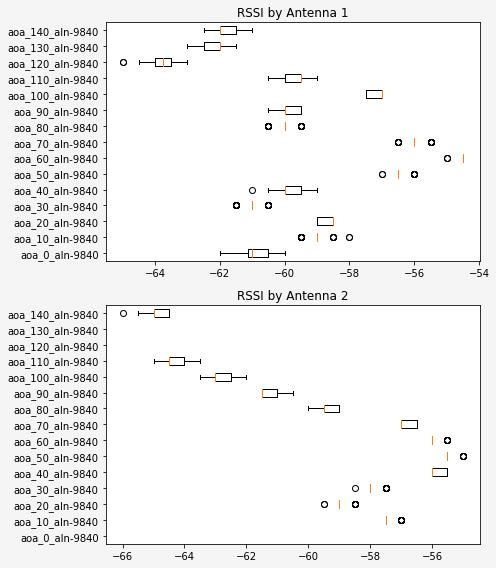

In [387]:
fig, axes = plt.subplots(2, 1, tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=7, h=8)
antenna1_data = [df["antenna1.rssi"].to_list() for df in data_dict.values()]
antenna2_data = [df["antenna2.rssi"].to_list() for df in data_dict.values()]
axes[0].boxplot(antenna1_data, labels=data_dict.keys(), vert=False)
axes[0].set_title("RSSI by Antenna 1")
axes[1].boxplot(antenna2_data, labels=data_dict.keys(), vert=False)
axes[1].set_title("RSSI by Antenna 2")
plt.show()

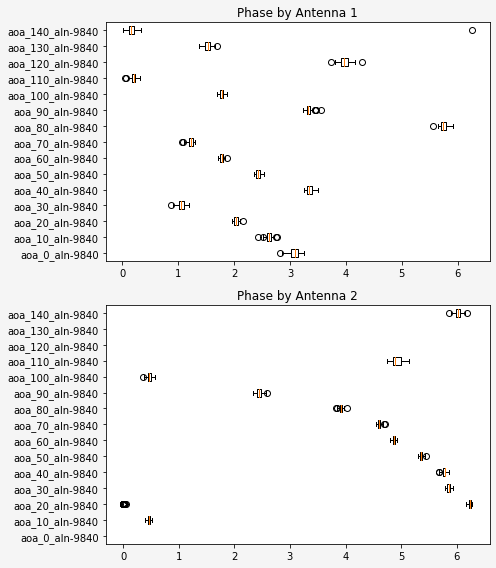

In [388]:
fig, axes = plt.subplots(2, 1, tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=7, h=8)
antenna1_data = [df["antenna1.phase"].to_list() for df in data_dict.values()]
antenna2_data = [df["antenna2.phase"].to_list() for df in data_dict.values()]
axes[0].boxplot(antenna1_data, labels=data_dict.keys(), vert=False)
axes[0].set_title("Phase by Antenna 1")
axes[1].boxplot(antenna2_data, labels=data_dict.keys(), vert=False)
axes[1].set_title("Phase by Antenna 2")
plt.show()

# MUSIC Method 

## MUSIC Class

In [389]:
import cmath


class MUSIC:
    def __init__(
        self,
        antenna_count: int,
        tag_count: int,
        sampling_count: int,
        antenna_space: float,
        signal_matrix: np.array,
        wave_length: float,
    ) -> None:
        self.M = antenna_count  # The number of Antenna
        self.K = tag_count  # The number of RF-tag
        self.N = sampling_count  # The number of sample
        self.d = antenna_space  # The space between antennas
        self.S = signal_matrix  # The matrix of signal
        self.l = wave_length  # The wave length of the signal
        self.theta_range = np.arange(0, 180.001, 0.001)

    def get_steering_vector(self, low_data: pd.DataFrame):
        phase_data = low_data[[f"antenna{m}.phase" for m in range(1, self.M + 1)]]
        for m in range(1, self.M + 1):
            if m == 1:
                phase_data[f"antenna{m}.phase_diff"] = 0
            else:
                phase_data[f"antenna{m}.phase_diff"] = (
                    phase_data[f"antenna{m}.phase"] - phase_data[f"antenna{m-1}.phase"]
                )
            phase_data[f"antenna{m}.a_theta"] = phase_data[
                f"antenna{m}.phase_diff"
            ].map(lambda x: cmath.exp(complex(0, -1 * self.d * (m - 1) * x)))
        phase_data = phase_data.drop(
            columns=[f"antenna{m}.phase" for m in range(1, self.M + 1)]
        )
        phase_data = phase_data.drop(
            columns=[f"antenna{m}.phase_diff" for m in range(1, self.M + 1)]
        )
        phase_data_mean = phase_data.mean()
        phase_data_array = phase_data_mean.to_numpy(dtype=complex)
        return phase_data_array.reshape(self.M, self.K)

    def get_correlation_matrix(self, steering_vector):
        print(np.dot(steering_vector, np.conjugate(steering_vector.reshape(self.K, self.M))))
        return (
            np.dot(
                np.dot(steering_vector, self.S.reshape(self.K, self.K)),
                np.conjugate(steering_vector.reshape(self.K, self.M)),
            )
        )

    def get_eigenvectors(self, correlation_matrix):
        l, p = np.linalg.eig(correlation_matrix)
        return p

    def get_noise_subspace(self, eigenvectors):
        return eigenvectors[:, self.K :].reshape(self.M, self.M - self.K)

    def get_music_spectrum(self, noise_subspace):
        noise_subspaceH = np.conjugate(noise_subspace.reshape(self.M - self.K, self.M))
        P = np.array([], dtype=float)
        for theta in self.theta_range:
            aH = np.array(
                [
                    np.exp(
                        complex(
                            0,
                            -1 * 2 * np.pi * (m - 1) * self.d * np.sin(theta) / self.l,
                        )
                    )
                    for m in range(1, self.M + 1)
                ]
            )
            a = np.conjugate(aH.reshape(self.M, 1))
            P = np.append(
                P, (np.dot(aH, a) / np.sum(np.abs(np.dot(noise_subspaceH, a))))[0].real
            )
            # P = np.append(P, (np.dot(aH, a) / np.dot(np.dot(np.dot(aH, noise_subspace), noise_subspaceH), a))[0].real)
        return P


In [390]:
df = data_dict["aoa_90_aln-9840"]
music = MUSIC(antenna_count=M, tag_count=K, sampling_count=N, antenna_space=L, signal_matrix=S, wave_length=WAVE_LENGTH)
steering_vector = music.get_steering_vector(low_data=df)
# print(steering_vector)
correlation_matrix = music.get_correlation_matrix(steering_vector=steering_vector)
print(correlation_matrix)
eigenvectors = music.get_eigenvectors(correlation_matrix=correlation_matrix)
# print(eigenvectors)
noise_subspace = music.get_noise_subspace(eigenvectors=eigenvectors)
# print(noise_subspace)
music_spectrum = music.get_music_spectrum(noise_subspace=noise_subspace)
# print(music_spectrum)

[[ 1.        +0.00000000e+00j -0.18841445-3.83323391e-02j]
 [-0.18841445+3.83323391e-02j  0.03696937-3.70798274e-19j]]
[[30.        +0.00000000e+00j -5.65243359-1.14997017e+00j]
 [-5.65243359+1.14997017e+00j  1.10908123-3.42995227e-17j]]


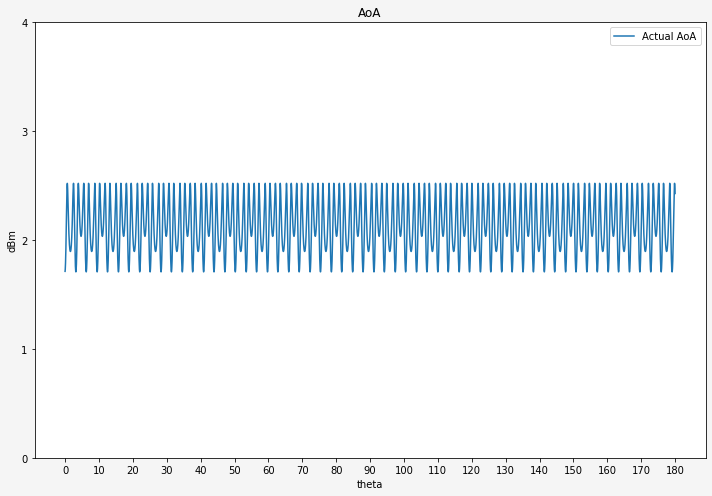

In [391]:
fig, ax = plt.subplots(tight_layout=True, facecolor="whitesmoke")
fig.set_size_inches(w=10, h=7)
ax.plot(music.theta_range, music_spectrum, label="Actual AoA")
ax.set_yticks(np.arange(0, 5, step=1))
ax.set_xticks(np.arange(0, 181, step=10))
ax.set_title("AoA")
ax.set_xlabel("theta")
ax.set_ylabel("dBm")
ax.legend()
plt.show()